In [1149]:
# Basic Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sci-kit learn imports
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [1150]:
# 1 - Load CSV file
penguins = pd.read_csv("penguins.csv")

In [1151]:
# 1 a) i) Convert categorical features to dummy code (1-hot encoding)
data = pd.get_dummies(penguins, columns=['island', 'sex'], dtype=int)
X = data.to_numpy()[:, 1:10]
y = data.to_numpy()[:, 0]

In [1152]:
# 1 a) ii) Convert features into categories
peng_array = penguins.to_numpy()
'''
for feature in peng_array:
    if feature[1] == "Torgersen":
        feature[1] = 0
    if feature[1] == "Dream":
        feature[1] = 1
    if feature[1] == "Biscoe":
        feature[1] = 2
    if feature[6] == "MALE":
        feature[6] = 0
    if feature[6] == "FEMALE":
        feature[6] = 1

X = peng_array[:, 1:7]
y = peng_array[:, 0]
'''

'\nfor feature in peng_array:\n    if feature[1] == "Torgersen":\n        feature[1] = 0\n    if feature[1] == "Dream":\n        feature[1] = 1\n    if feature[1] == "Biscoe":\n        feature[1] = 2\n    if feature[6] == "MALE":\n        feature[6] = 0\n    if feature[6] == "FEMALE":\n        feature[6] = 1\n\nX = peng_array[:, 1:7]\ny = peng_array[:, 0]\n'

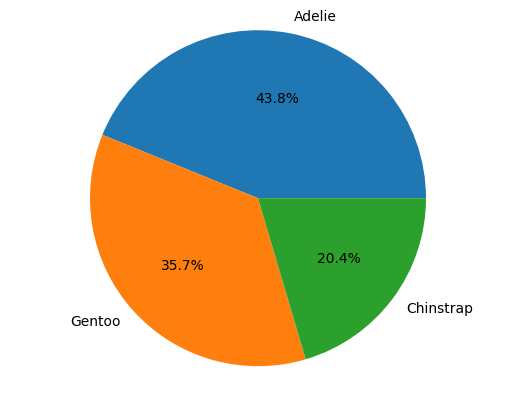

In [1153]:
# 2 - Percentages of each output class
labels = 'Adelie', 'Gentoo', 'Chinstrap'
sizes = penguins['species'].value_counts(normalize=True) * 100

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.savefig("penguin-classes")

In [1154]:
# 3 - Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y)

dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

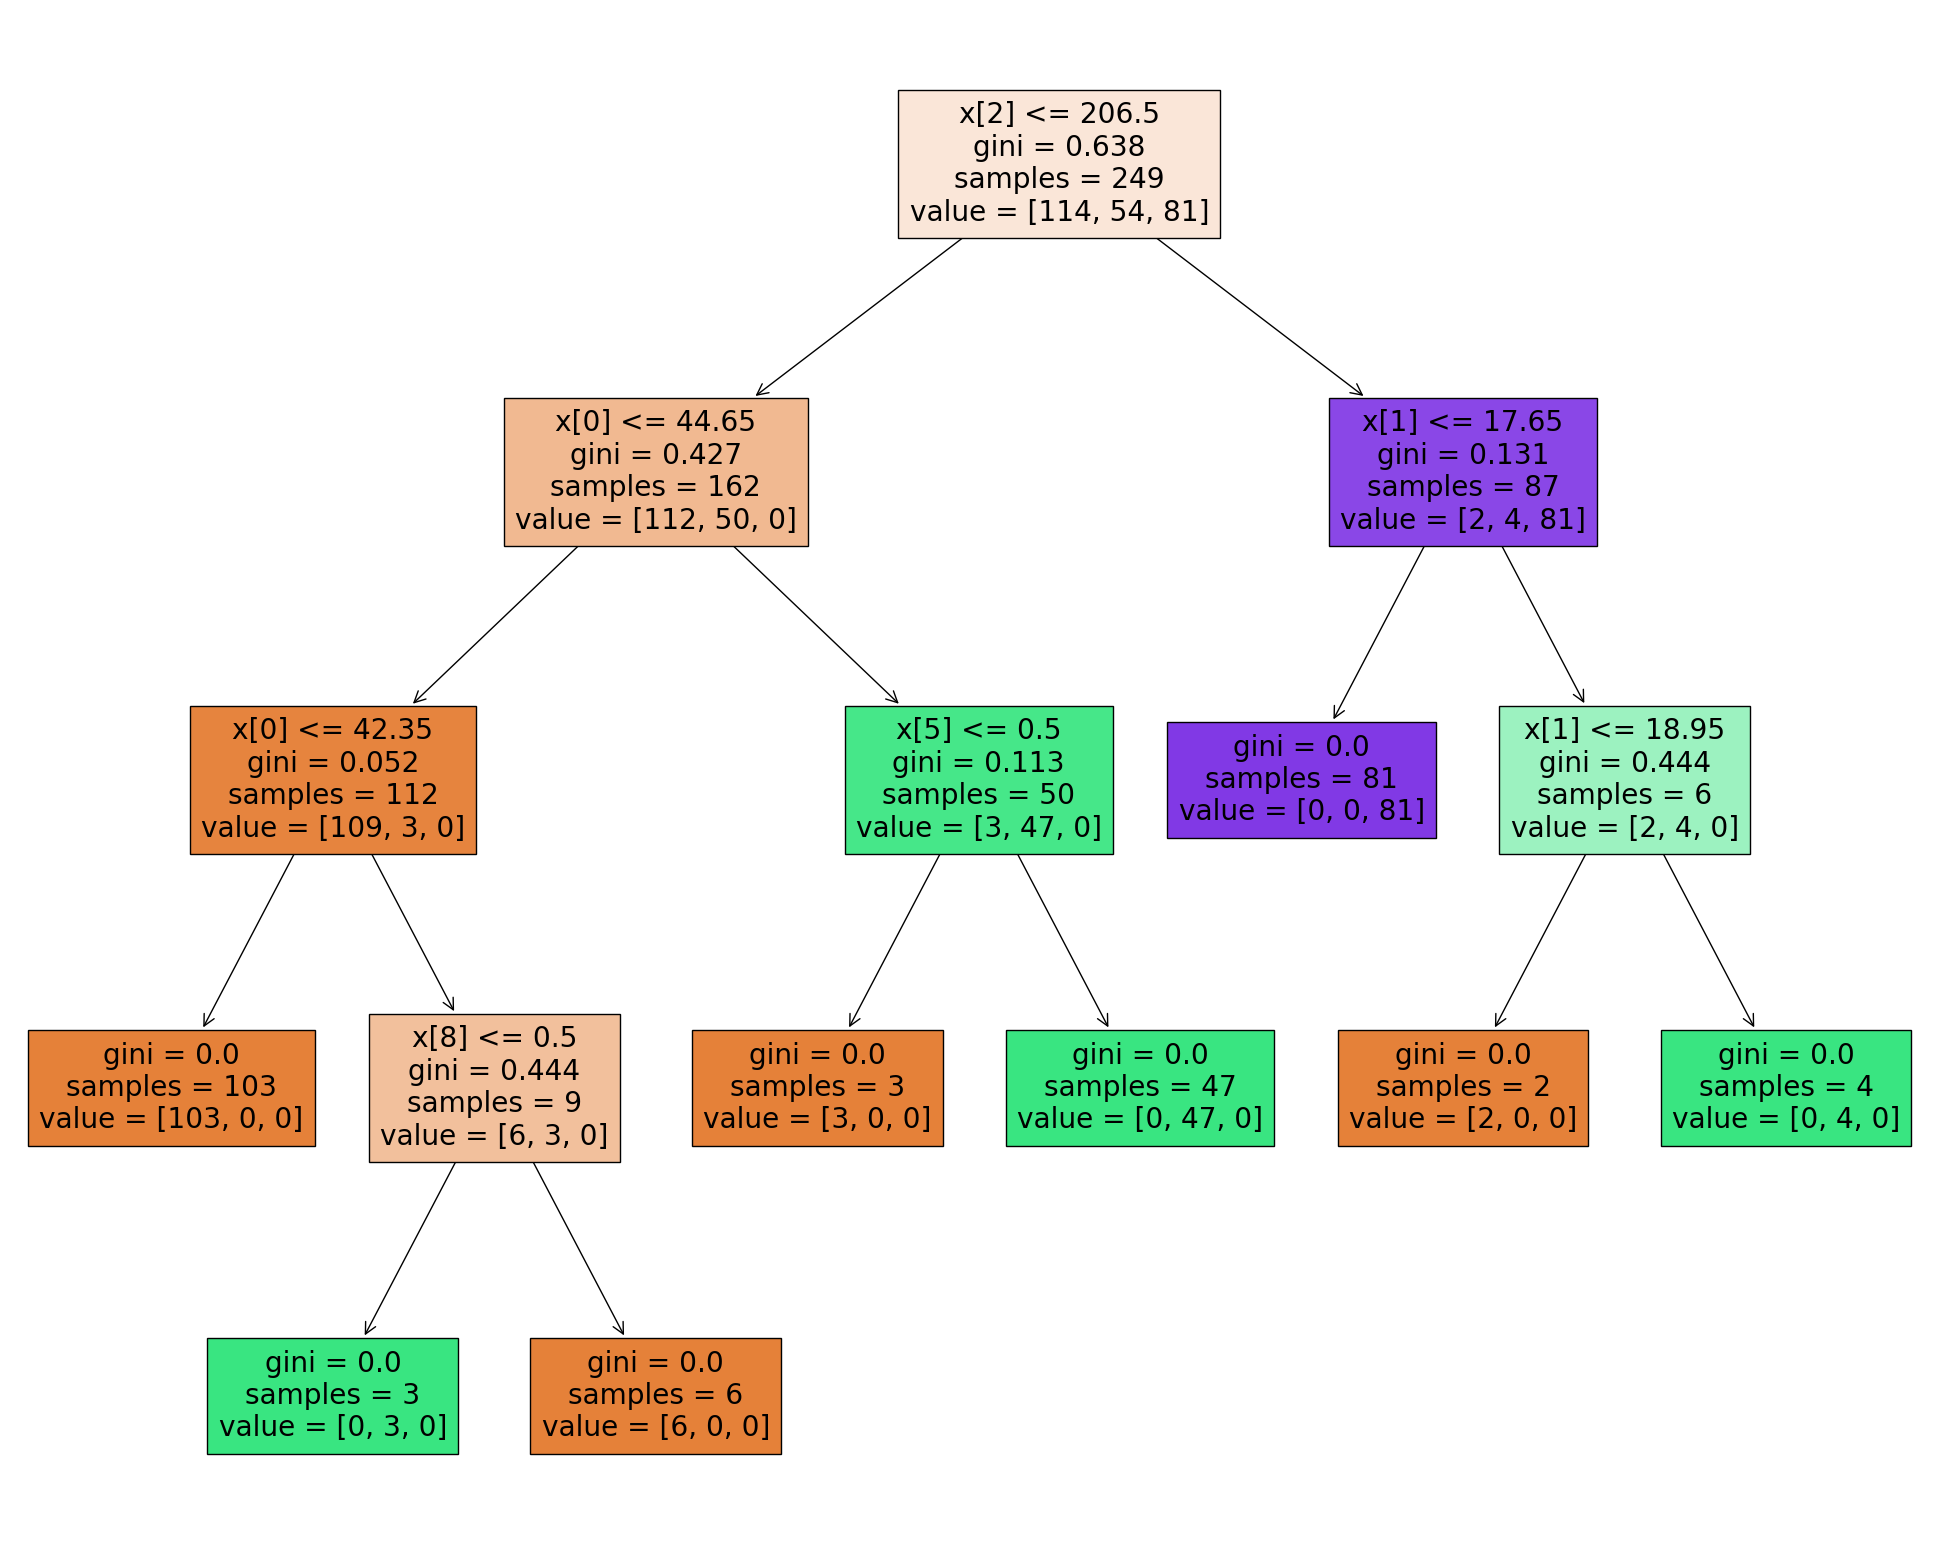

In [1155]:
# 4 a) Base DT
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, filled=True)

In [1156]:
# 4 b) Top DT
tree_para = {'criterion':['gini','entropy'],'max_depth':[3,7,None], 'min_samples_split':[2,3,5]}
dtc2 = tree.DecisionTreeClassifier()
grid = GridSearchCV(dtc2, tree_para)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}
0.9839183673469387


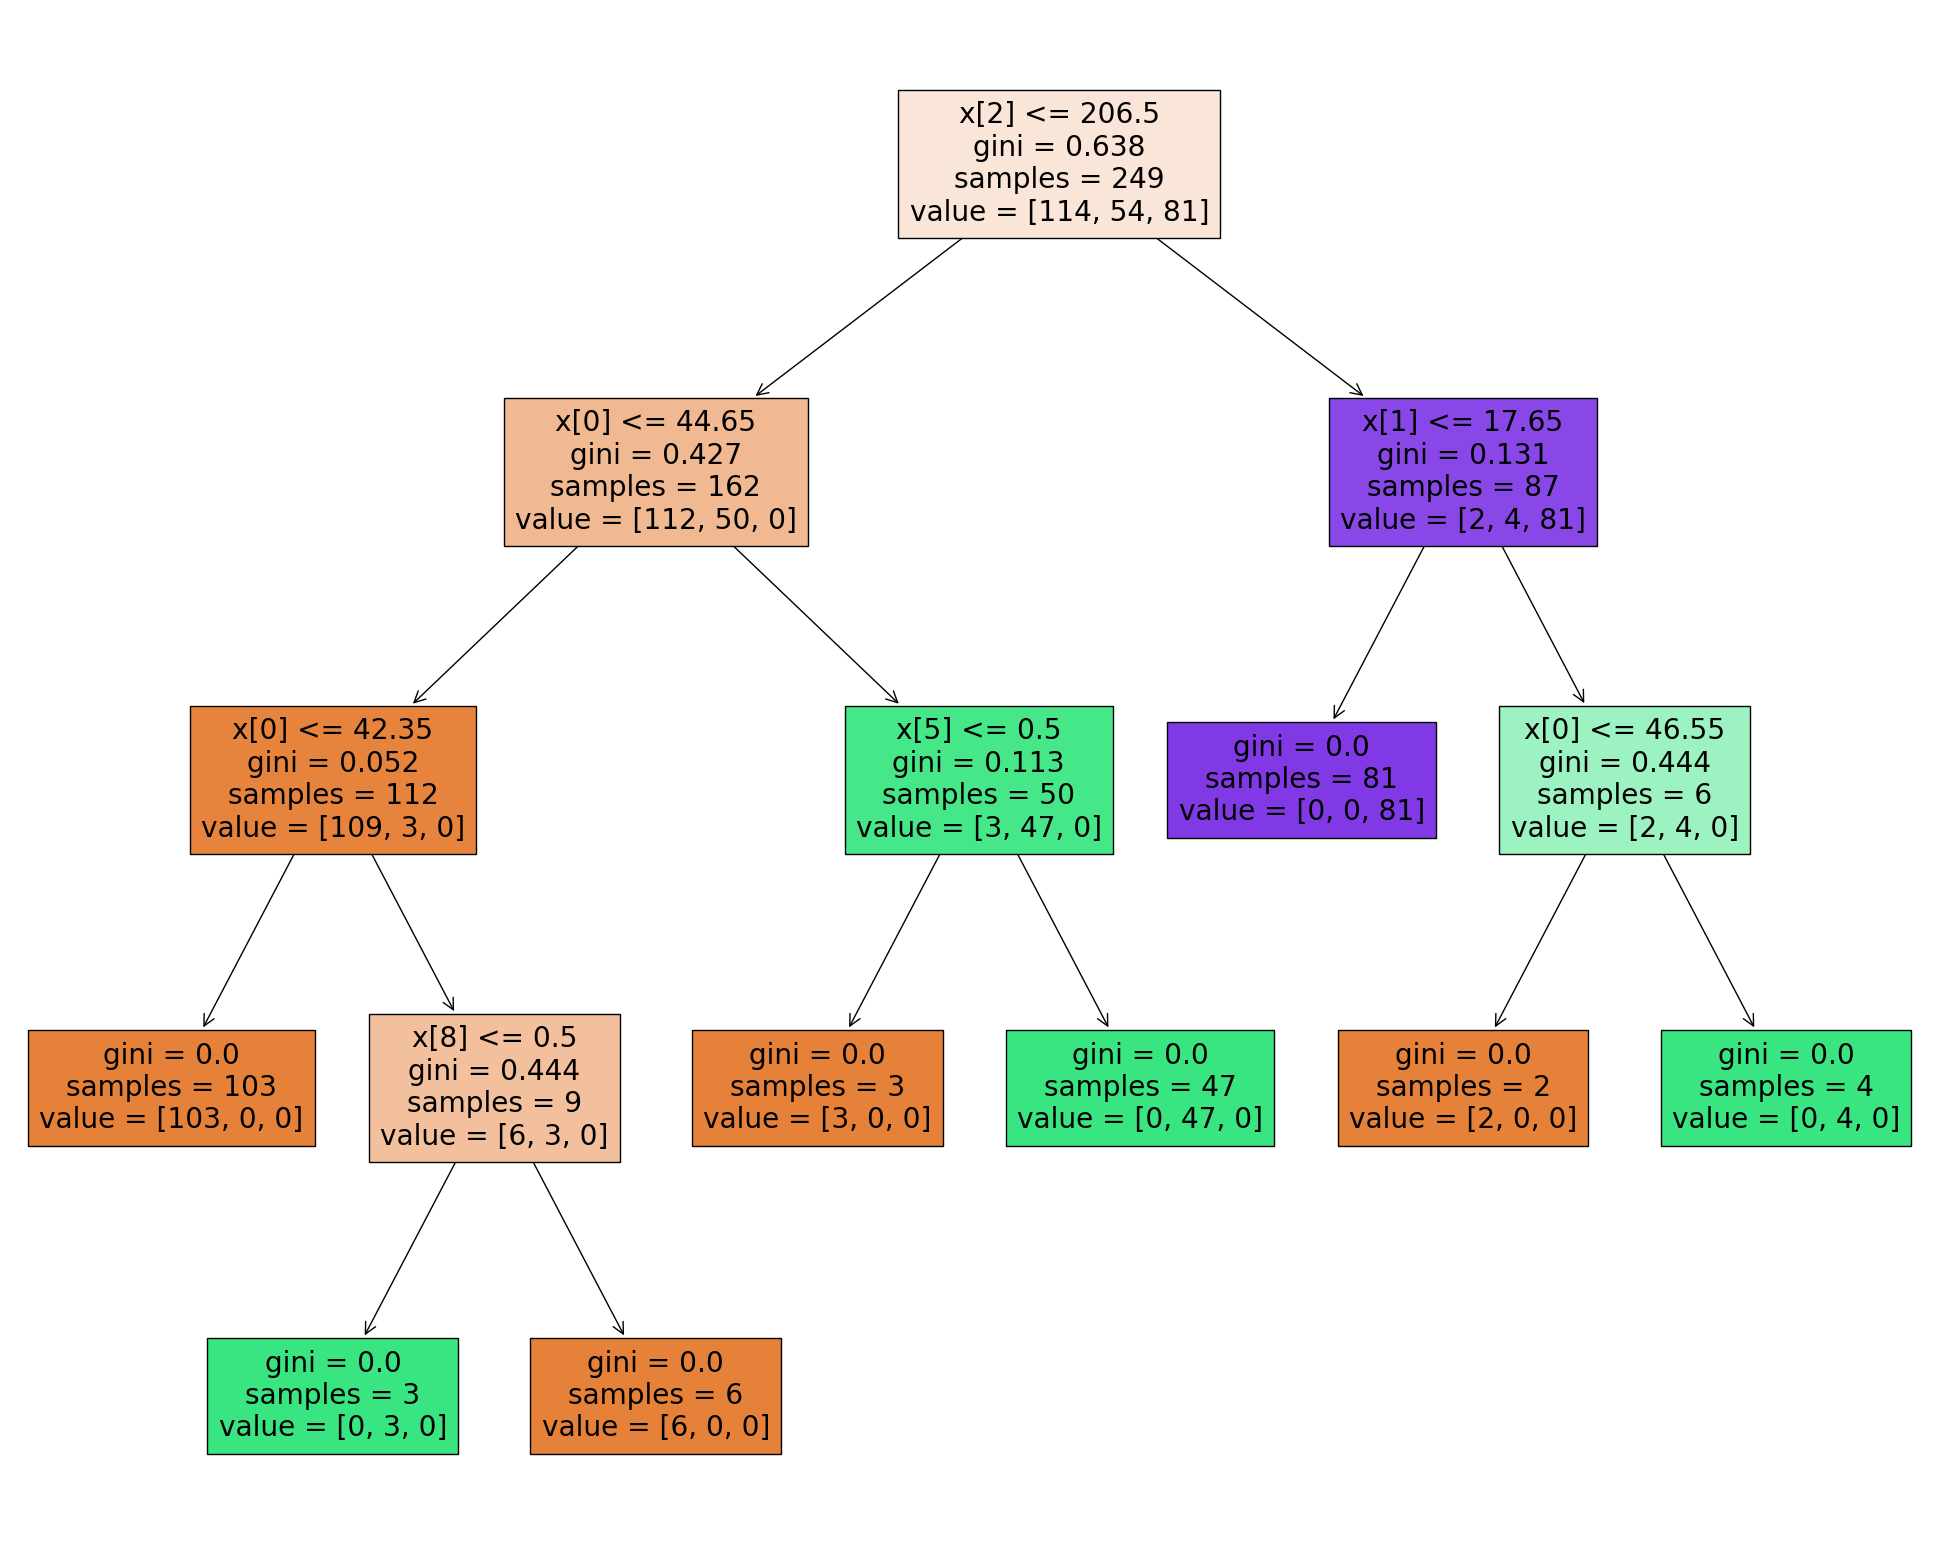

In [1157]:
# Plot Top DT
top_dtc = tree.DecisionTreeClassifier()
top_dtc.set_params(**grid.best_params_)
top_dtc.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(top_dtc, filled=True)

In [1158]:
# 5) Function to create confusion matrices
def plotConfusionMatrix(y_true, y_pred, classes, normalize = True, title = None, cmap = plt.cm.Blues,):
    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    #Ticks
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), 
           #labels
           xticklabels = classes, yticklabels = classes,
           title = title, ylabel = 'True label', xlabel = "Predicted label")
    
    #Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

    #Loop over data dimensions ad create text annotations
    fmt = '0.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center",
                    color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)


In [1159]:
#Open file to write to
fp = open('penguin-performance.txt', 'w')

              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        32
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       1.00      0.97      0.99        38

    accuracy                           0.98        84
   macro avg       0.98      0.97      0.97        84
weighted avg       0.98      0.98      0.98        84



3

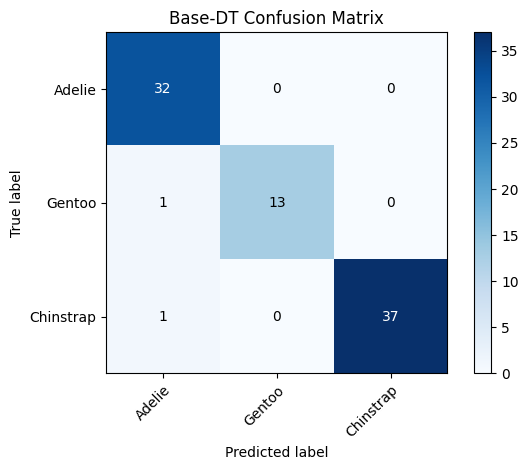

In [1160]:
#Creating the confusion matrix for the Base-DT
fp.write('Base-DT with default parameters')
fp.write('\n \n')

y_predBaseDT = dtc.predict(X_test)
class_names = data.species.value_counts().index
plotConfusionMatrix(y_test, y_predBaseDT, classes=class_names, normalize = False, title = "Base-DT Confusion Matrix")
fp.write("Confusion matrix: ")
fp.write('\n \n')
fp.write(str(confusion_matrix(y_test, y_predBaseDT)))
fp.write('\n \n')

# Creating the classification report for the Base-DT
print(classification_report(y_test, y_predBaseDT))
fp.write("Classification report:")
fp.write('\n \n')
fp.write(classification_report(y_test, y_predBaseDT))
fp.write('\n')

# 6) Repeating the Base-DT and finding all averages and variance
precisionScoresBDT = []
macroF1ScoresBDT = []
weightedF1ScoresBDT = []

for run in range(5):
    dtcBDT = tree.DecisionTreeClassifier()
    dtcBDT.fit(X_train, y_train)

    y_predBDT = dtcBDT.predict(X_test)

    precisionScoresBDT.append(dtcBDT.score(X_test, y_test))
    macroF1ScoresBDT.append(f1_score(y_test, y_predBDT, average='macro'))
    weightedF1ScoresBDT.append(f1_score(y_test, y_predBDT, average='weighted'))



# Writing all the information to the file
toWrite = "Average accuracy: " + str(np.mean(precisionScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresBDT))
fp.write(toWrite)
fp.write('\n \n')



              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        32
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       1.00      0.97      0.99        38

    accuracy                           0.98        84
   macro avg       0.98      0.97      0.97        84
weighted avg       0.98      0.98      0.98        84



3

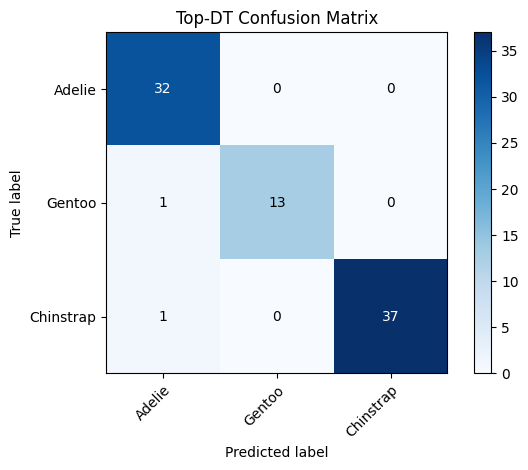

In [1161]:
# Plotting confusion matrix for the Top-DT
fp.write('---------------------------------------------------------------------------------------------------------------')
fp.write('\n \n')
fp.write('Top-DT where the criterion, max_depth, and min_samples_split were changed')
fp.write('\n')
fp.write('Best hyperparameters found by gridsearch: ' + str(grid.best_params_))
fp.write('\n \n')

y_predTopDT = top_dtc.predict(X_test)
class_names = data.species.value_counts().index
plotConfusionMatrix(y_test, y_predTopDT, classes=class_names, normalize = False, title = "Top-DT Confusion Matrix")
fp.write("Confusion matrix: ")
fp.write('\n \n')
fp.write(str(confusion_matrix(y_test, y_predTopDT)))
fp.write('\n \n')

# Creating the classification report for the Top-DT
print(classification_report(y_test, y_predTopDT))
fp.write("Classification report:")
fp.write('\n \n')
fp.write(classification_report(y_test, y_predTopDT))
fp.write('\n \n')




# 6) Repeating the Top-DT and finding all averages and variance
precisionScoresTDT = []
macroF1ScoresTDT = []
weightedF1ScoresTDT = []

for run in range(5):
    tree_para = {'criterion':['gini','entropy'],'max_depth':[3,7,None], 'min_samples_split':[2,3,5]}
    dtcTDT = tree.DecisionTreeClassifier()
    grid = GridSearchCV(dtcTDT, tree_para)
    grid.fit(X_train,y_train)

    dtcTDT.set_params(**grid.best_params_)
    dtcTDT.fit(X_train, y_train)


    y_predTDT = dtcTDT.predict(X_test)

    precisionScoresTDT.append(dtcTDT.score(X_test, y_test))
    macroF1ScoresTDT.append(f1_score(y_test, y_predTDT, average='macro'))
    weightedF1ScoresTDT.append(f1_score(y_test, y_predTDT, average='weighted'))



# Writing all the information to the file
toWrite = "Average accuracy: " + str(np.mean(precisionScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresTDT))
fp.write(toWrite)
fp.write('\n \n')


In [1162]:
# Closing the text file
fp.close()